# Q-learning is a value-based learning algorithm, that aims to find the best step or action to take based on the maximum Q-value. 

In [1]:
!pip install gym

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827646 sha256=3adf89a381b070ce714db0e837b5980c152487b48a9019cf480e06c10473ae4b
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\af\2b\30\5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym


In [2]:
!pip install gym[toy_text]

In [3]:
import numpy as np
print('numpy: %s' % np.__version__) # print version

# Note need to 'pip install gym', and 'pip install gym[toy_text]' 
                                  # or 'pip install gym\[toy_text\]' if zsh does nor recongize the first command
import gym # for simulated environments
print('gym: %s' % gym.__version__) # print version

import matplotlib
import matplotlib.pyplot as plt # for displaying environment states
print('matplotlib: %s' % matplotlib.__version__) # print version

from IPython import display # for displaying environment states
import time # for slowing down rendering of states by adding small time delays

numpy: 1.20.3
gym: 0.26.2
matplotlib: 3.4.3


In [4]:
# Setup environment
env = gym.make(id='FrozenLake-v1', # Choose one of the existing environments
               desc=None, # Used to specify custom map for frozen lake. E.g., desc=["SFFF", "FHFH", "FFFH", "HFFG"].
               map_name='4x4', # ID to use any of the preloaded maps. E.g., '4x4', '8x8'
               is_slippery=False, # True/False. If True will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.
               max_episode_steps=None, # default=None, Maximum length of an episode (TimeLimit wrapper).
               autoreset=False, # default=None, Whether to automatically reset the environment after each episode (AutoResetWrapper).
               disable_env_checker=None, # default=None, If to run the env checker
               render_mode = 'rgb_array' # The set of supported modes varies per environment. (And some third-party environments may not support rendering at all.)
              )

In [5]:
# Show environment description (map) as an array
print("Environment Array: ")
print(env.desc)

# Observation and action space 
state_obs_space = env.observation_space # Returns sate(observation) space of the environment.
action_space = env.action_space # Returns action space of the environment.
print("State(Observation) space:", state_obs_space)
print("Action space:", action_space)

Environment Array: 
[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]
State(Observation) space: Discrete(16)
Action space: Discrete(4)


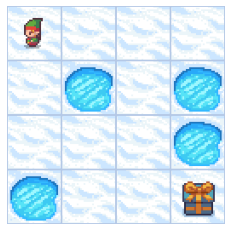

In [6]:

# Reset environment to initial state
state, info = env.reset()

# Cycle through 20 random steps redering and displaying the agent inside the environment each time
for _ in range(20):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Sample a random action from the entire action space
    random_action = env.action_space.sample()
    
    # Pass the random action into the step function
    state, reward, done, _, info = env.step(random_action)
        
    # Wait a little bit before the next frame
    time.sleep(0.2)
    
    # Reset environment when done=True, i.e., when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display current state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        # Reset environment
        state, info = env.reset()

# Close environment 
env.close()

Gamma is a measure of the agent's tendency to look forward to future rewards. The smaller it is, the more the agent will tend to take the action with the greatest reward, regardless of resultant state. Agents with larger gamma will learn long paths to big rewards
Another critical aspect of rewards is the discount factor (gamma). It can range between 0 and 1, but we would typically choose a value between 0.95 and 0.99. The purpose of a discount factor is to give us control over the preference for short-term vs long-term rewards.
alpha: is the learning rate, set generally between 0 and 1. Setting the alpha value to 0 means that the Q-values are never updated, thereby nothing is learned. If we set the alpha to a high value such as 0.9, it means that the learning can occur quickly.
Episodes: When an agent ends up in a terminating state and can't take a new action. Q-Values: Used to determine how good an Action, A, taken at a particular state, S, is. Q (A, S). Temporal Difference: A formula used to find the Q-Value by using the value of current state and action and previous state and action.
Episode: All states that come in between an initial-state and a terminal-state;
This process was repeated for a specified number of episodes, allowing the agent to learn and improve its decision-making capabilities.
In this case one episode is since the start point until the goal. Take many episodes are the different ways to get into the goal with steps into each episode, during each episode the agent learns and improves its decision making capabiltites. 

In [7]:
# Q-function parameters
alpha = 0.7   # learning rate
gamma = 0.95  # discount factor

# Training parameters
n_episodes = 10000  # number of episodes to use for training
n_max_steps = 100   # maximum number of steps per episode

# Exploration / Exploitation parameters
start_epsilon = 1.0  # start training by selecting purely random actions
min_epsilon = 0.05   # the lowest epsilon allowed to decay to
decay_rate = 0.001   # epsilon will gradually decay so we do less exploring and more exploiting as Q-function improves

Note that we will vary epsilon throughout training. We will start with epsilon=1, meaning that our agent’s actions will be all random at the beginning. However, we will decay epsilon with every episode, so our agent gradually moves from pure exploration to exploitation.

In [8]:
env.observation_space

Discrete(16)

Next, let’s initialise the Q-table. As we’ve seen in the previous section, it will be a 16x4 table where 16 rows represent 16 states, and 4 columns represent 4 possible actions. We initialise the Q-table with all 0’s since we do not know how valuable each state is before we start the training.

In [10]:
# Initial Q-table
# Our Q-table is a matrix of state(observation) space x action space, i.e., 16 x 4
Qtable = np.zeros((env.observation_space.n, env.action_space.n))

# Show
Qtable

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [11]:

# This is our acting policy (epsilon-greedy), for the agent to do exploration and exploitation during training
def epsilon_greedy(Qtable, state, epsilon):
    # Generate a random number and compare to epsilon, if lower then explore, itherwuse exploit
    randnum = np.random.uniform(0, 1)
    if randnum < epsilon:
        action = env.action_space.sample()    # explore
    else:
        action = np.argmax(Qtable[state, :])  # exploit
    return action


# This is our updating policy (greedy) 
# i.e., always select the action with the highest value for that state: np.max(Qtable[next_state])
def update_Q(Qtable, state, action, reward, next_state):
    # Q(S_t,A_t) = Q(S_t,A_t) + alpha [R_t+1 + gamma * max Q(S_t+1,a) - Q(S_t,A_t)]
    Qtable[state][action] = Qtable[state][action] + alpha * (reward + gamma * np.max(Qtable[next_state]) - Qtable[state][action])
    return Qtable


# This function (also greedy) will return the action from Qtable when we do evaluation
def eval_greedy(Qtable, state):
    action = np.argmax(Qtable[state, :])
    return action

# Epsilon starts at 1, meaning that the agent will always start with explore the environment and learning from its mistakes to find the best actions through cumulative reward maximization. Once epsilon is small enough,min_epsilon = 0.05,the agent starts to do more  exploitation, choosing the best action according to the maximum Q value in the next state. 

In [12]:
def train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable):
    for episode in range(n_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        
        # Calculate epsilon value based on decay rate
        epsilon = max(min_epsilon, (start_epsilon - min_epsilon)*np.exp(-decay_rate*episode))
        
        for t in range(n_max_steps):
            # Choose an action using previously defined epsilon greedy policy
            action = epsilon_greedy(Qtable, state, epsilon)
            
            # Perform the action in the environment, get reward and next state
            next_state, reward, done, _, info = env.step(action)
            
            # Update Q-table
            Qtable = update_Q(Qtable, state, action, reward, next_state)
            
            # Update current state 
            state = next_state
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
    # Return final Q-table
    return Qtable

# Q-table after training gets its best Q-values, it converges or gets into its maximum number of episodes. 

In [13]:
# Train
Qtable = train(n_episodes, n_max_steps, start_epsilon, min_epsilon, decay_rate, Qtable)

# Show Q-table
Qtable

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77347807, 0.70396669],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [14]:
def evaluate_agent(n_max_steps, n_eval_episodes, Qtable):
    # Initialize an empty list to store rewards for each episode
    episode_rewards=[]
    
    # Evaluate for each episode
    for episode in range(n_eval_episodes):
        
        # Reset the environment at the start of each episode
        state, info = env.reset()
        t = 0
        done = False
        tot_episode_reward = 0
        
        for t in range(n_max_steps):
            
            # Use greedy policy to evaluate
            action = eval_greedy(Qtable, state)

            # Pass action into step function
            next_state, reward, done, _, info = env.step(action)

            # Sum episode rewards
            tot_episode_reward += reward

            # Update current state 
            state = next_state
            
            # Finish the episode when done=True, i.e., reached the goal or fallen into a hole
            if done:
                break
                
        episode_rewards.append(tot_episode_reward)
        
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [15]:
# Call the above evaluation function and display the results:
n_eval_episodes=100 # evaluate over 100 episodes
mean_reward, std_reward = evaluate_agent(n_max_steps, n_eval_episodes, Qtable)
print(f"Mean Reward & Std_Deviation = {mean_reward:.2f} +/- {std_reward:.2f}")

Mean Reward & Std_Deviation = 1.00 +/- 0.00


As you can see, in every episode out of 100 episodes tested, the agent managed to get the maximum reward (1.00).

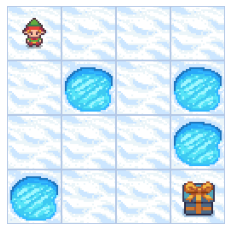

In [17]:
# Cycle through 19 steps redering and displaying environment state each time
state, info = env.reset()
for _ in range(19):
    
    # Render and display current state of the environment
    plt.imshow(env.render()) # render current state and pass to pyplot
    plt.axis('off')
    display.display(plt.gcf()) # get current figure and display
    display.clear_output(wait=True) # clear output before showing the next frame
    
    # Use greedy policy to evaluate
    action = eval_greedy(Qtable, state)
    
    # Pass action into step function
    state, reward, done, _, info = env.step(action)

    # Wait a little bit before the next frame
    time.sleep(0.2)
    
    # Reset environment when done=True, i.e. when the agent falls into a Hole (H) or reaches the Goal (G)
    if done:
        # Render and display final state of the environment
        plt.imshow(env.render()) # render current state and pass to pyplot
        plt.axis('off')
        display.display(plt.gcf()) # get current figure and display
        display.clear_output(wait=True) # clear output before showing the next frame
        state, info = env.reset()

env.close()

Since the location G has the top priority it is possible to define the matrix of rewards as follows, giving a high reward for the location G:

In [18]:
import numpy as np

R = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 1, 0, 0, 0, 1000, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

In [11]:
gamma = 0.75

alpha = 0.9

Q−values are being initialized by a matrix of zeros:

In [21]:
Q = np.array(np.zeros([12, 12]))

In [22]:
Q

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Then the Q−Learning process is implemented, with a for loop over 1000 iterations, repeating 1000 times the steps of the algorithm:

In [30]:
for i in range(1000):
    current_state = np.random.randint(0,12)
    playable_actions = []
    for j in range(12):
        if R[current_state, j] > 0:
            playable_actions.append(j)
            next_state = np.random.choice(playable_actions)
            TD = R[current_state, next_state] + gamma*Q[next_state, np.argmax(Q[next_state,])] - Q[current_state, next_state]
            Q[current_state, next_state] = Q[current_state, next_state] + alpha*TD

# Q-table optimal values after iterations of the algorithm:

In [31]:
Q

array([[   0.        , 1689.81198928,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [1268.35899196,    0.        , 2251.74946888,    0.        ,
           0.        , 1268.3589901 ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        , 1689.81199053,    0.        ,    0.        ,
           0.        ,    0.        , 3000.99929383,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        , 2251.74947304,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
         715.20183063,    0.        ,    0. 

In [32]:
import pandas as pd

In [33]:
# Create the pandas DataFrame
df = pd.DataFrame(Q, columns = ['A', 'B','C','D','E','F','G','H','I','J','K','L'])

# Check the q table with the q-values that guide the steps to take: Rows are the location and columns are actions meaning to what location we should move. Follow the maximum q-values as the action to move to the optimal location until we reach the final destiny location, in this case G. 

# For example if we are in location 'A' row 0 we should move to location 'B', then the maximum q-value is 'C' 2251 and after we reach the ending location 'G' with maximum Q-value 3000

# From the visualized table, it is possible to see that the location G got the highest Q−value, while locations far from G got a lower Q−value.

In [34]:
df

,A,B,C,D,E,F,G,H,I,J,K,L
0,0.000000,1689.811989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1268.358992,0.000000,2251.749469,0.000000,0.000000,1268.358990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1689.811991,0.000000,0.000000,0.000000,0.000000,3000.999294,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2251.749473,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,715.201831,0.000000,0.000000,0.000000
5,0.000000,1689.811988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,952.268523,0.000000,0.000000
6,0.000000,0.000000,2251.749321,0.000000,0.000000,0.000000,3999.999088,2251.749470,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,1689.812105,0.000000,0.000000,3000.999316,0.000000,0.000000,0.000000,0.000000,1689.811891
8,0.000000,0.000000,0.000000,0.000000,537.401039,0.000000,0.000000,0.000000,0.000000,952.269108,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,1268.358991,0.000000,0.000000,715.201787,0.000000,1268.358206,0.000000


In [1]:
location_to_state = {'A': 0,
                     'B': 1,
                     'C': 2,
                     'D': 3,
                     'E': 4,
                     'F': 5,
                     'G': 6,
                     'H': 7,
                     'I': 8,
                     'J': 9,
                     'K': 10,
                     'L': 11}

In [2]:

# Making a mapping from the states to the locations

state_to_location = {state: location for location, 
                     state in location_to_state.items()}

In [3]:
state_to_location

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L'}

In [6]:
import numpy as np

In [7]:
R = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1],
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]])

Then the Q−Learning process is implemented, with a for loop over 1000, these are called episodes, iterations repeating 1000 times the steps of the algorithm:

In [8]:
def route(starting_location, ending_location):
    R_new = np.copy(R)
    ending_state = location_to_state[ending_location]
    R_new[ending_state, ending_state] = 1000
    Q = np.array(np.zeros([12,12]))
    for i in range(1000):
        current_state = np.random.randint(0,12)
        playable_actions = []
        for j in range(12):
            if R_new[current_state, j] > 0:
                playable_actions.append(j)
        next_state = np.random.choice(playable_actions)
        TD = R_new[current_state, next_state] + gamma * Q[next_state, np.argmax(Q[next_state,])] - Q[current_state, next_state]
        Q[current_state, next_state] = Q[current_state, next_state] + alpha * TD
    route = [starting_location]
    next_location = starting_location
    while (next_location != ending_location):
        starting_state = location_to_state[starting_location]
        next_state = np.argmax(Q[starting_state,])
        next_location = state_to_location[next_state]
        route.append(next_location)
        starting_location = next_location
    return route

In [9]:
location_to_state['G']

6

the ending state route in the function will always be the maximum score value. 
R_new[ending_state, ending_state] = 1000

In [12]:
route("E", "G")

['E', 'I', 'J', 'F', 'B', 'C', 'G']

In [16]:
route("C", "G")

['C', 'G']

In [17]:
route("A", "L")

['A', 'B', 'F', 'J', 'K', 'L']

In [13]:
def best_route(starting_location, intermediary_location, ending_location):
    return route(starting_location, intermediary_location) + route(intermediary_location, ending_location)[1:]

In [14]:
best_route("E", "K", "G")

['E', 'I', 'J', 'K', 'L', 'H', 'G']

# The goal here is to reach 5. That is why once you can reach from certain state the reward is 100. 

In [19]:
import numpy as np
import copy 

# Environemnts 
rewards = np.array([[-float('inf'), -float('inf'), 0, 0, -float('inf'), -float('inf'), -float('inf')],
           [-float('inf'), -float('inf'), -float('inf'), -float('inf'), 0, -float('inf'), 0],
           [0, -float('inf'), -float('inf'), 0, -float('inf'), 100, -float('inf')],
           [0, -float('inf'), 0, -float('inf'), 0, -float('inf'), -float('inf')],
           [-float('inf'), 0, -float('inf'), 0, -float('inf'), 100, 0],
           [-float('inf'), -float('inf'), 0, -float('inf'), 0, 100, 0],
           [-float('inf'), 0, -float('inf'), -float('inf'), 0, 100, -float('inf')]])

In [20]:
#when it cannot reach that value the reward is negative. 
rewards 

array([[-inf, -inf,   0.,   0., -inf, -inf, -inf],
       [-inf, -inf, -inf, -inf,   0., -inf,   0.],
       [  0., -inf, -inf,   0., -inf, 100., -inf],
       [  0., -inf,   0., -inf,   0., -inf, -inf],
       [-inf,   0., -inf,   0., -inf, 100.,   0.],
       [-inf, -inf,   0., -inf,   0., 100.,   0.],
       [-inf,   0., -inf, -inf,   0., 100., -inf]])

In [21]:
all_states = np.arange(len(rewards))
all_states

array([0, 1, 2, 3, 4, 5, 6])

In [22]:
rewards[0]

array([-inf, -inf,   0.,   0., -inf, -inf, -inf])

In [23]:
rewards[0][0]

-inf

In [24]:
rewards[2][0]

0.0

In [82]:
#the action in this case has to be position 2 or 3. Actions are the columns, states are the rows. 
np.random.choice(np.where(rewards[0] != -float('inf'))[0])

3

In [84]:
#the action in this case has to be position 4 or 6. Actions
np.random.choice(np.where(rewards[1] != -float('inf'))[0])

4

In [87]:
# Parameters
gamma = 0.8
alpha = 0.01
num_episode = 50000
min_difference = 1e-3
goal_state = 5

In [88]:
def QLearning(rewards, goal_state=None, gamma=0.99, alpha=0.01, num_episode=1000, min_difference=1e-5):
    """ 
    Run Q-learning loop for num_episode iterations or till difference between Q is below min_difference.
    """
    Q = np.zeros(rewards.shape)
    all_states = np.arange(len(rewards))
    for i in range(num_episode):
         #copy Q to have it before the initilize the state until the difference is below minimum it converges. 
        Q_old = copy.deepcopy(Q)
         # initialize state
        initial_state = np.random.choice(all_states)
        action = np.random.choice(np.where(rewards[initial_state] != -float('inf'))[0])
        #Q starts with zeros and through iterations you will start getting the Q-values ubto the Q matrix. 
        Q[initial_state][action] = Q[initial_state][action] + alpha * (rewards[initial_state][action] + gamma * np.max(Q[action]) - Q[initial_state][action])
        #the action moves you to a new number between 0,6. 
        cur_state = action
        # loop for each step of episode, until reaching goal state
        #the loop continues iterating until it reaches the goal_state. And episode is done once it reaches the final goal=5. 
        while cur_state != goal_state:
            # choose action form states using policy derived from Q
            action = np.random.choice(np.where(rewards[cur_state] != -float('inf'))[0])
            #formula of Q-learning to update the q matrix. 
            Q[cur_state][action] = Q[cur_state][action] + alpha * (rewards[cur_state][action] + gamma * np.max(Q[action]) - Q[cur_state][action])
            cur_state = action
            
            # break the loop if converge
        diff = np.sum(Q - Q_old)
        if diff < min_difference:
            break
    return np.around(Q/np.max(Q)*100)

In [89]:
Q = QLearning(rewards, goal_state=goal_state, gamma=gamma, alpha=alpha, num_episode=num_episode, min_difference=min_difference)           
Q

array([[  0.,   0.,  80.,  64.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  80.,   0.,  80.],
       [ 64.,   0.,   0.,  64.,   0., 100.,   0.],
       [ 64.,   0.,  80.,   0.,  80.,   0.,   0.],
       [  0.,  64.,   0.,  64.,   0., 100.,  80.],
       [  0.,   0.,  79.,   0.,  80.,  99.,  80.],
       [  0.,  64.,   0.,   0.,  80., 100.,   0.]])

According to the above Q-table, we can select actions based on the maximum Q value. E.g. If the agent is in room 1, it will have 2 different routes that can lead to room 5. From room 1 agent can either move to room 4 or room 6 which give the same maximum Q-value of 80. Afterwards, the agent will then move to room 5 in both cases which gives the maximum Q-value of 100. Similarly, if the agent is in room 3, it can either move to room 1 or room 4 which give the same maximum Q-value.



Once the matrix Q gets close enough to a state of convergence, we know our agent has learned the most optimal paths to the goal state.  Tracing the best sequences of states is as simple as following the links with the highest values at each state.

In [109]:
#Initial Reward table: 
# defines the reward/connection graph
r = np.array([[-1, -1, -1, -1,  0,  -1],
              [-1, -1, -1,  0, -1, 100],
              [-1, -1, -1,  0, -1,  -1],
              [-1,  0,  0, -1,  0,  -1],
              [ 0, -1, -1,  0, -1, 100],
              [-1,  0, -1, -1,  0, 100]]).astype("float32")

In [110]:
r

array([[ -1.,  -1.,  -1.,  -1.,   0.,  -1.],
       [ -1.,  -1.,  -1.,   0.,  -1., 100.],
       [ -1.,  -1.,  -1.,   0.,  -1.,  -1.],
       [ -1.,   0.,   0.,  -1.,   0.,  -1.],
       [  0.,  -1.,  -1.,   0.,  -1., 100.],
       [ -1.,   0.,  -1.,  -1.,   0., 100.]], dtype=float32)

In [111]:
r[r == -1] =  -float('inf')

In [118]:
r

array([[-inf, -inf, -inf, -inf,   0., -inf],
       [-inf, -inf, -inf,   0., -inf, 100.],
       [-inf, -inf, -inf,   0., -inf, -inf],
       [-inf,   0.,   0., -inf,   0., -inf],
       [  0., -inf, -inf,   0., -inf, 100.],
       [-inf,   0., -inf, -inf,   0., 100.]], dtype=float32)

In [107]:
import numpy as np
from numpy import inf
r[-1] = -float('inf')

In [113]:
all_states = np.arange(len(r))
all_states

array([0, 1, 2, 3, 4, 5])

In [114]:
initial_state = np.random.choice(all_states)
initial_state

2

In [116]:
#it is okat because if the intial_state is 2, the only possible action is 3. 
action = np.random.choice(np.where(r[initial_state] != -float('inf'))[0])
action

3

In [96]:
# Parameters
gamma = 0.8
alpha = 0.01
num_episode = 50000
min_difference = 1e-3
goal_state = 5

In [119]:
def QLearning(r, goal_state=None, gamma=0.99, alpha=0.01, num_episode=1000, min_difference=1e-5):
    """ 
    Run Q-learning loop for num_episode iterations or till difference between Q is below min_difference.
    """
    Q = np.zeros(r.shape)
    all_states = np.arange(len(r))
    for i in range(num_episode):
         #copy Q to have it before the initilize the state until the difference is below minimum it converges. 
        Q_old = copy.deepcopy(Q)
         # initialize state
        initial_state = np.random.choice(all_states)
        action = np.random.choice(np.where(r[initial_state] != -float('inf'))[0])
        #Q starts with zeros and through iterations you will start getting the Q-values ubto the Q matrix. 
        Q[initial_state][action] = Q[initial_state][action] + alpha * (r[initial_state][action] + gamma * np.max(Q[action]) - Q[initial_state][action])
        #the action moves you to a new number between 0,6. 
        cur_state = action
        # loop for each step of episode, until reaching goal state
        #the loop continues iterating until it reaches the goal_state. And episode is done once it reaches the final goal=5. 
        while cur_state != goal_state:
            # choose action form states using policy derived from Q
            action = np.random.choice(np.where(r[cur_state] != -float('inf'))[0])
            #formula of Q-learning to update the q matrix. 
            Q[cur_state][action] = Q[cur_state][action] + alpha * (r[cur_state][action] + gamma * np.max(Q[action]) - Q[cur_state][action])
            cur_state = action
            
            # break the loop if converge
        diff = np.sum(Q - Q_old)
        if diff < min_difference:
            break
    #This matrix Q, can then be normalized (i.e.; converted to a percentage) by dividing all non-zero entries by the highest number (500 in this case):
    return np.around(Q/np.max(Q)*100)

In [121]:
#This matrix Q, can then be normalized (i.e.; converted to a percentage) by dividing all non-zero entries by the highest number (100 in this case):
Q = QLearning(r, goal_state=goal_state, gamma=gamma, alpha=alpha, num_episode=num_episode, min_difference=min_difference)           
Q

array([[  0.,   0.,   0.,   0.,  80.,   0.],
       [  0.,   0.,   0.,  64.,   0., 100.],
       [  0.,   0.,   0.,  64.,   0.,   0.],
       [  0.,  80.,  51.,   0.,  80.,   0.],
       [ 64.,   0.,   0.,  64.,   0., 100.],
       [  0.,  80.,   0.,   0.,  80., 100.]])

# The Q-table tells you what action to take at each state, row, choosing the action, column, with the maximum Q-value. 

# ---------------------------------------------------------------------------------------------------------------

# Q-Learning in continuous data. 

In [148]:
import gym

In [168]:
env = gym.make("MountainCar-v0")
env.reset()

(array([-0.5298077,  0.       ], dtype=float32), {})

In [150]:
print(env.observation_space.high)

[0.6  0.07]


In [151]:
len(env.observation_space.high)

2

In [152]:
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)

In [153]:
DISCRETE_OS_SIZE

[20, 20]

# Continous combinations of position and velocity. We bucket them in 20 chunks to make them discrete. 

In [154]:
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

[0.6  0.07]
[-1.2  -0.07]
3


In [155]:
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

In [156]:
discrete_os_win_size

array([0.09 , 0.007])

each bucket in position will be of 0.09 long and velocity 0.007 long. 

In [157]:
#we need to initialize the q-table. 

In [159]:
#there are 400 possible states combinations and three actions possible once you are in a specific state. 
20*20

400

In [160]:
import numpy as np

...

q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

In [161]:
q_table

array([[[-0.96556645, -0.88429797, -1.76775255],
        [-0.98711735, -0.32365406, -0.69664689],
        [-0.09777549, -0.42699011, -1.0819586 ],
        ...,
        [-1.76790336, -0.55422591, -1.49138013],
        [-0.73804907, -0.82316365, -1.42619415],
        [-1.54293098, -1.3600856 , -1.19118413]],

       [[-1.00214502, -0.25517223, -0.3450664 ],
        [-1.16290455, -1.55871979, -1.82702012],
        [-0.8631403 , -0.12497247, -1.14595198],
        ...,
        [-1.92176329, -0.01794846, -0.35224831],
        [-0.49966425, -0.85492851, -1.67373407],
        [-0.64432006, -0.32639226, -0.40598396]],

       [[-0.32382247, -0.59632345, -1.57462288],
        [-1.42898391, -1.61337062, -0.27758755],
        [-0.03104938, -1.31486439, -0.02007024],
        ...,
        [-1.79629339, -1.91097784, -0.62079261],
        [-0.32561602, -0.80263066, -0.71161523],
        [-0.28949458, -0.51942906, -1.20044436]],

       ...,

       [[-1.82881061, -0.51313023, -1.10224225],
        [-0

In [162]:
 q_table.shape

(20, 20, 3)

In [163]:
 q_table[0]

array([[-0.96556645, -0.88429797, -1.76775255],
       [-0.98711735, -0.32365406, -0.69664689],
       [-0.09777549, -0.42699011, -1.0819586 ],
       [-0.69358976, -1.94373463, -0.71946746],
       [-1.32679782, -0.97370453, -0.18098662],
       [-0.54397738, -1.1629218 , -1.9489977 ],
       [-0.73890787, -0.66494428, -0.22394878],
       [-1.46518847, -0.14680535, -1.19459733],
       [-1.84347935, -1.12043745, -0.5184723 ],
       [-1.57683856, -0.12867059, -1.59998659],
       [-0.14053563, -1.48371607, -0.16007241],
       [-1.10920944, -0.87790287, -1.98882839],
       [-0.21948636, -0.7843647 , -1.39943169],
       [-0.30634835, -1.55806027, -0.46402232],
       [-1.5640447 , -1.74198784, -0.19857068],
       [-0.58129926, -0.12445778, -1.30418078],
       [-1.3866946 , -0.69955619, -0.06889262],
       [-1.76790336, -0.55422591, -1.49138013],
       [-0.73804907, -0.82316365, -1.42619415],
       [-1.54293098, -1.3600856 , -1.19118413]])

In [164]:
#first chunk of 20 possible stages with its rewards. The columns are the possible actions. 
#the total possible position and velocity combinations, stages, is 400. 
q_table[0].shape

(20, 3)

#the q table start only having random values rewards. (Negative random values are better than 0)

In [236]:
#Both parameters range from 0 to 1. 
LEARNING_RATE = 0.1
#It is how much we value future reward over current reward
DISCOUNT = 0.95
EPISODES = 25000
#show every 2000 episodes that the loop is still running. 
SHOW_EVERY =2000

Next, we need a quick helper-function that will convert our environment "state," which currently contains continuous values that would wind up making our Q-Table absolutely gigantic and take forever to learn.... to a "discrete" state instead:

In [216]:
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table

In [248]:
#env.reset() gives us the initial state.
env.reset()[0]

array([-0.47363952,  0.        ], dtype=float32)

In [249]:
discrete_state = get_discrete_state(env.reset()[0])

C:\Users\Admin\AppData\Local\Temp/ipykernel_10472/2708959218.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table


In [221]:
discrete_state

(6, 10)

In [ ]:
#below are the Q-values for the below state. 

In [222]:
q_table[discrete_state]

array([-0.76896619, -0.74382084, -0.41412108])

#At the beginning there are random numbers, so are meaningless.

In [223]:
#choose the action with hte maximum q-value. 
action = np.argmax(q_table[discrete_state])
action

2

In [225]:
 env.step(action)

(array([-0.56870073,  0.0027251 ], dtype=float32), -1.0, False, False, {})

In [232]:
 for x in env.step(action):
    print(x)

[-0.5145431  0.0111193]
-1.0
False
False
{}


In [246]:
 for x in env.reset():
    print(x)

[-0.42089877  0.        ]
{}


In [237]:
# Exploration settings
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

In [251]:
for episode in range(EPISODES):
    discrete_state = get_discrete_state(env.reset()[0])
    done = False
    while not done:
    #choose the action base on maximum q-value. 
        action = np.argmax(q_table[discrete_state])
        new_state,reward,done, _,_ = env.step(action)
        new_discrete_state = get_discrete_state(new_state)
        env.render()
        # If simulation did not end yet after last step - update Q table
        if not done:

            # Maximum possible Q value in next step (for new state)
            max_future_q = np.max(q_table[new_discrete_state])

            # Current Q value (for current state and performed action)
            current_q = q_table[discrete_state + (action,)]

            # And here's our equation for a new Q value for current state and action
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            # Update Q table with new Q value
            q_table[discrete_state + (action,)] = new_q
            # Simulation ended (for any reson) - if goal position is achived - update Q value with reward directly
            #the reward is 0, no punishment. 
        elif new_state[0] >= env.goal_position:
            #q_table[discrete_state + (action,)] = reward
            q_table[discrete_state + (action,)] = 0
        #in order for the loop to continue. 
        discrete_state = new_discrete_state
        
        # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value


env.close()

C:\Users\Admin\AppData\Local\Temp/ipykernel_10472/2708959218.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table


The above code only runs one time and it is not usefull, We want to iterate through episodes. without: for episode in range(EPISODES): 

# After training we have the new Q-table with the optimal Q-values to take the best actions in each state. Remember that we convert continous states to discrete in order to create a reliable new q-table avaible to learn, otherwise it would have taken forever! Infinite state possibilities. 

In [252]:
#new_q_table_updated. 
q_table

array([[[-9.65566450e-01, -8.84297968e-01, -1.76775255e+00],
        [-1.38074270e+01, -1.36809824e+01, -1.37616171e+01],
        [-1.76243207e+01, -1.76264890e+01, -1.76156576e+01],
        ...,
        [-1.76790336e+00, -5.54225912e-01, -1.49138013e+00],
        [-7.38049073e-01, -8.23163650e-01, -1.42619415e+00],
        [-1.54293098e+00, -1.36008560e+00, -1.19118413e+00]],

       [[-1.00214502e+00, -2.55172229e-01, -3.45066403e-01],
        [-1.61229025e+01, -1.61474093e+01, -1.61510324e+01],
        [-1.77422165e+01, -1.77314893e+01, -1.77407026e+01],
        ...,
        [-1.92176329e+00, -1.79484616e-02, -3.52248315e-01],
        [-4.99664249e-01, -8.54928511e-01, -1.67373407e+00],
        [-6.44320064e-01, -3.26392262e-01, -4.05983963e-01]],

       [[-2.66540545e+00, -3.08402997e+00, -2.95249200e+00],
        [-1.66859248e+01, -1.68164924e+01, -1.67805892e+01],
        [-1.78284598e+01, -1.80144464e+01, -1.80227219e+01],
        ...,
        [-1.79629339e+00, -1.91097784e+00,